In [18]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings

from itertools import cycle

In [ ]:
project_dir_path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/"
temp_files_path = project_dir_path+'TempFiles/'
dataset_name = 'traintest_data5.pkl'  # Dataset filename - change this to switch datasets

# Load In Data

In [ ]:
import pickle

save_path = temp_files_path
file_name = dataset_name

with open(save_path+file_name, 'rb') as f:
    PROCESSED_DATASET = pickle.load(f)

(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET


print("X_train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))
print("period_train: ", np.shape(period_train))
print("period_test: ", np.shape(period_test))
print("y_train: ", np.shape(y_train))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)
print("\n⚠️  NOTE: Data is RAW (unscaled). Preprocessing will be applied before training.")

# Create Validation Split from Training Data

In [21]:
# ============================================================
# CREATE VALIDATION SPLIT FROM TRAINING DATA
# ============================================================
# IMPORTANT: Never use test set during training!
# Split training data into train (90%) and validation (10%) subsets

print("\n" + "="*70)
print("CREATING VALIDATION SPLIT")
print("="*70)

# Get unique clusters from training data
unique_train_clusters = np.unique(train_cluster_names)
n_train_clusters = len(unique_train_clusters)
n_val_clusters = int(0.2 * n_train_clusters)  # 20% of clusters for validation

print(f"\nTotal training clusters: {n_train_clusters}")
print(f"Validation clusters (10%): {n_val_clusters}")
print(f"Training clusters (90%):   {n_train_clusters - n_val_clusters}")

# Randomly select validation clusters
np.random.seed(42)  # For reproducibility
val_cluster_indices = np.random.choice(n_train_clusters, size=n_val_clusters, replace=False)
val_clusters = unique_train_clusters[val_cluster_indices]

print(f"\nValidation clusters: {val_clusters[:5]}..." if len(val_clusters) > 5 else f"\nValidation clusters: {val_clusters}")

# Create masks for train/val split
val_mask = np.isin(train_cluster_names, val_clusters)
train_mask = ~val_mask

# Split the data
X_train_split = X_train[train_mask]
X_val_split = X_train[val_mask]

period_train_split = period_train[train_mask]
period_val_split = period_train[val_mask]

y_train_split = y_train[train_mask]
y_val_split = y_train[val_mask]

train_cluster_names_split = train_cluster_names[train_mask]
val_cluster_names_split = train_cluster_names[val_mask]

print(f"\n✅ Split complete!")
print(f"   Train set:      {X_train_split.shape[0]} samples from {len(np.unique(train_cluster_names_split))} clusters")
print(f"   Validation set: {X_val_split.shape[0]} samples from {len(np.unique(val_cluster_names_split))} clusters")
print(f"   Test set:       {X_test.shape[0]} samples from {len(np.unique(test_cluster_names))} clusters (held out for final evaluation)")
print("="*70)


CREATING VALIDATION SPLIT

Total training clusters: 313
Validation clusters (10%): 62
Training clusters (90%):   251

Validation clusters:      name    
-------------
   Cl Kron 31
  BERKELEY 50
      NGC2123
     NGC 6167
Cl Lindsay 65...

✅ Split complete!
   Train set:      3066 samples from 251 clusters
   Validation set: 906 samples from 62 clusters
   Test set:       436 samples from 35 clusters (held out for final evaluation)


In [22]:
# Full histogram illustrating the data:
import sys
sys.path.append(project_dir_path+'HelperFcns/')


from VisualizeDataset import visualize_feature_distributions, visualize_mass_bin_distribution
from VisualizeDataset import visualize_summary_stats, plot_correlation_matrix

visualize=False
if visualize:
    #visualize_feature_distributions(X_train, feature_cols)
    visualize_mass_bin_distribution(y_train, y_test)
    visualize_summary_stats(X_train, y_train, feature_cols)
    plot_correlation_matrix(X_train, feature_names=feature_cols, figsize=(14, 11), annot=True)
    #plot_correlation_matrix(period_train, feature_names=None, figsize=(14, 11), annot=False)


# Define The NN Model

In [23]:
# Load in yt datasets
import sys
sys.path.append(project_dir_path)

from GaussianNN_wPeriodogram import DualInputNN

# Load in all the training functions and helper functions

In [24]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Import training functions from helper file
import sys
sys.path.append(project_dir_path)

from Training_HelperFcns import (
    GaussianNLLLoss_ME, 
    sanitize_batch,
    Run_Single_Batch, 
    Run_Single_Epoch, 
    Train_Model,
    log_model_progress,
    plot_run_log
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in best model params

In [25]:
# ============================================================
# LOAD BEST MODEL PARAMETERS
# ============================================================

import pickle

# Load the best parameters exported from 1_HyperparamTuning.ipynb
load_path = temp_files_path + 'best_model_params.pkl'

with open(load_path, 'rb') as f:
    best_config = pickle.load(f)

# Extract the parameters
best_params = best_config['params']
best_epoch = best_config['best_epoch']

# *** IMPORTANT: Override num_kfolds for single-model training ***
# The hyperparameter tuning used K-fold CV, but here we train ONE model on full data
best_params['num_kfolds'] = 1  # Must be 1 for plotting functions to work correctly

# Display what was loaded
print("="*70)
print("LOADED BEST MODEL CONFIGURATION")
print("="*70)
print(f"Model Name:      {best_config['model_name']}")
print(f"Run ID:          {best_config['run_id']}")
print(f"Composite Score: {best_config['composite_score']:.4f}")
print(f"Best Epoch:      {best_epoch}")

print(f"\nValidation Metrics @ Best Epoch:")
print(f"  Loss:          {best_config['metrics']['loss']:.4f}")
print(f"  Coverage@68%:  {best_config['metrics']['cov68']:.4f}")
print(f"  Coverage@95%:  {best_config['metrics']['cov95']:.4f}")
print(f"  {best_config['metrics']['err_metric1_name']}: {best_config['metrics']['err1']:.4f}")
print(f"  {best_config['metrics']['err_metric2_name']}: {best_config['metrics']['err2']:.4f}")

print(f"\nHyperparameters:")
for key, value in best_params.items():
    print(f"  {key:30s} = {value}")

print(f"\nRanking Info:")
print(f"  Total models evaluated: {best_config['ranking_info']['total_models_evaluated']}")
print(f"  Metric weights: {best_config['ranking_info']['metric_weights']}")
print("="*70)

LOADED BEST MODEL CONFIGURATION
Model Name:      Test_Model
Run ID:          1
Composite Score: 0.2836
Best Epoch:      32

Validation Metrics @ Best Epoch:
  Loss:          -0.0577
  Coverage@68%:  0.6792
  Coverage@95%:  0.9446
  valid_median_sigma: 0.4850
  valid_MAE: 0.4399

Hyperparameters:
  Layer1_Size                    = 16
  Layer2_Size                    = 8
  artificial_loss_weight_factor  = 1
  batch_size                     = 4
  decoupled                      = False
  dropout_prob                   = 0.3
  learn_sigma                    = True
  lr                             = 0.0001
  n_epochs                       = 50
  n_layers                       = 2
  num_kfolds                     = 1
  use_cnn                        = False
  use_periodogram                = True
  weight_decay                   = 1e-06

Ranking Info:
  Total models evaluated: 15
  Metric weights: {'loss': 0, 'cov68': 1, 'cov95': 1, 'err1': 0.3, 'err2': 0.3}


# Setup Data and Training Configuration

In [26]:
# ============================================================
# SETUP DATA AND TRAINING CONFIGURATION
# ============================================================

import time

# Define which datasets you wish to use
# Use the train/val SPLIT (not test set - that's for final evaluation only!)
summary_stat_dims = [X_train_split.shape[1]]
periodogram_dims = [period_train_split.shape[1]]

# Training data (90% of original train)
model_train_data_statistics  = [X_train_split]
model_train_data_periodogram = [period_train_split]
model_train_data_Y           = [y_train_split]

# Validation data (10% of original train - used for monitoring during training)
model_valid_data_statistics  = [X_val_split]
model_valid_data_periodogram = [period_val_split]
model_valid_data_Y           = [y_val_split]

model_names = ['Final_Best_Model']

# Initialize empty training log (same structure as K-fold)
empty_train_log = {
        "epoch" : [], 
        "mean_batch_loss" : [], 
        "train_errLoss" : [], 
        "train_sigmaLoss" : [], 
        "train_Loss" : [], 
        "train_MAE"  : [], 
        "train_RMSE" : [], 
        "train_median_sigma" : [], 
        "train_mean_sigma" : [], 
        "train_Coverage68" : [], 
        "train_Coverage95" : [], 
        "train_CRPS" : [], 
        "valid_errLoss" : [], 
        "valid_sigmaLoss" : [], 
        "valid_Loss" : [], 
        "valid_MAE"  : [], 
        "valid_RMSE" : [], 
        "valid_median_sigma" : [], 
        "valid_mean_sigma" : [], 
        "valid_Coverage68" : [], 
        "valid_Coverage95" : [], 
        "valid_CRPS" : [], 
}

# Create log structure (simpler - no K-fold, just one model)
final_model_log = {
    'params': best_params,
    'model': None,
    'log': copy.deepcopy(empty_train_log)
}

print("\n✅ Data and configuration setup complete")
print(f"   Training samples:   {X_train_split.shape[0]} (90% of original train)")
print(f"   Validation samples: {X_val_split.shape[0]} (10% of original train)")
print(f"   Test samples:       {X_test.shape[0]} (held out for final evaluation)")
print(f"\n   ⚠️  NOTE: Using validation split for monitoring, NOT test set!")


✅ Data and configuration setup complete
   Training samples:   3066 (90% of original train)
   Validation samples: 906 (10% of original train)
   Test samples:       436 (held out for final evaluation)

   ⚠️  NOTE: Using validation split for monitoring, NOT test set!


# Train Final Model on Full Training Set

In [27]:
# ============================================================
# TRAIN FINAL MODEL WITH VALIDATION SPLIT
# ============================================================

from Training_HelperFcns import apply_preprocessing

print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

for i, model_name in enumerate(model_names):    
    stats_dim = summary_stat_dims[i]
    period_dim = periodogram_dims[i]
    
    # Training data (90% of original train)
    X_stats_raw  = model_train_data_statistics[i]
    X_period_raw = model_train_data_periodogram[i]
    Y_raw        = model_train_data_Y[i]
    
    # Validation data (10% of original train - NOT test set!)
    valid_X_stats_raw  = model_valid_data_statistics[i]
    valid_X_period_raw = model_valid_data_periodogram[i]
    valid_Y_raw        = model_valid_data_Y[i]

    # Apply preprocessing (fit on train, transform both train and val)
    print(f"\n📊 Applying preprocessing (scaling, normalization)...")
    (X_stats, valid_X_stats,
     X_period, valid_X_period,
     Y, valid_Y,
     SCALER, y_mean, mean_peak_strength) = apply_preprocessing(
        X_stats_raw, valid_X_stats_raw,
        X_period_raw, valid_X_period_raw,
        Y_raw, valid_Y_raw
    )
    print(f"   ✅ Preprocessing complete")
    print(f"   Scaler mean: {SCALER.mean_[:3]}... (first 3 features)")
    print(f"   Target mean (y_mean): {y_mean:.4f}")
    if mean_peak_strength is not None:
        print(f"   Periodogram normalization factor: {mean_peak_strength:.6f}")

    # Check for NaNs
    if torch.isnan(X_stats).any():
        print("⚠️ Warning: NaNs detected in X_train")
    
    if torch.isnan(valid_X_stats).any():
        print("⚠️ Warning: NaNs detected in X_val")
    
    print(f"\nModel: {model_name}")
    print(f"Parameters: {best_params}")
    
    # Initialize model
    model_class = DualInputNN
    model_inputs = (
        stats_dim,
        period_dim,
        best_params['Layer1_Size'],
        best_params['dropout_prob'],
        best_params['use_periodogram'],
        best_params['use_cnn'],
        best_params['learn_sigma']
    )
    model = model_class(*model_inputs)
    
    # Prepare data (now properly preprocessed)
    training_data = (X_stats, X_period, Y)
    validation_data = (valid_X_stats, valid_X_period, valid_Y)  # Using validation split, NOT test!
    
    # Train the model with best checkpoint saving
    print(f"\n🚀 Starting training for {best_params['n_epochs']} epochs...")
    print(f"   Batch size: {best_params['batch_size']}")
    print(f"   Learning rate: {best_params['lr']}")
    print(f"   Dropout: {best_params['dropout_prob']}")
    print(f"   Weight decay: {best_params['weight_decay']}")
    print(f"   Tracking best model (smoothed over 3 epochs)")
    
    training_log = final_model_log['log']
    model, final_model_log['log'], final_train_loss, best_model_state, best_model_epoch = Train_Model(
        model, 
        training_data, 
        validation_data, 
        best_params, 
        training_log,
        save_best_checkpoint=True  # Enable best checkpoint tracking
    )
    
    # Store both final and best models
    final_model_log['final_model'] = model
    final_model_log['best_model_state'] = best_model_state
    final_model_log['best_model_epoch'] = best_model_epoch
    
    print(f"\n✅ Training complete!")
    print(f"   Final training loss: {final_train_loss:.4f}")
    print(f"   Best model saved from epoch: {best_model_epoch}")

print("="*70)


TRAINING FINAL MODEL

📊 Applying preprocessing (scaling, normalization)...
   ✅ Preprocessing complete
   Scaler mean: [0.12099577 0.00097381 0.0006332 ]... (first 3 features)
   Target mean (y_mean): 7.9012
   Periodogram normalization factor: 0.191236

Model: Final_Best_Model
Parameters: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0001, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 1, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}

🚀 Starting training for 50 epochs...
   Batch size: 4
   Learning rate: 0.0001
   Dropout: 0.3
   Weight decay: 1e-06
   Tracking best model (smoothed over 3 epochs)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 3042.4746)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 258.7685)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 353.6147)
[CLIP WARNING] Gradient norm was clipped to

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:210: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2342.2141)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 496.0596)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 353.5492)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 363.2921)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 5966.6582)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2852.1182)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 741.6332)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 296.1193)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 34846396.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 732.1489)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 519.1451)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 521.8510)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1157.6202)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (b

# Visualize Training Progress

In [28]:
final_model_log.keys()

dict_keys(['params', 'model', 'log', 'final_model', 'best_model_state', 'best_model_epoch'])


Generating training plots...


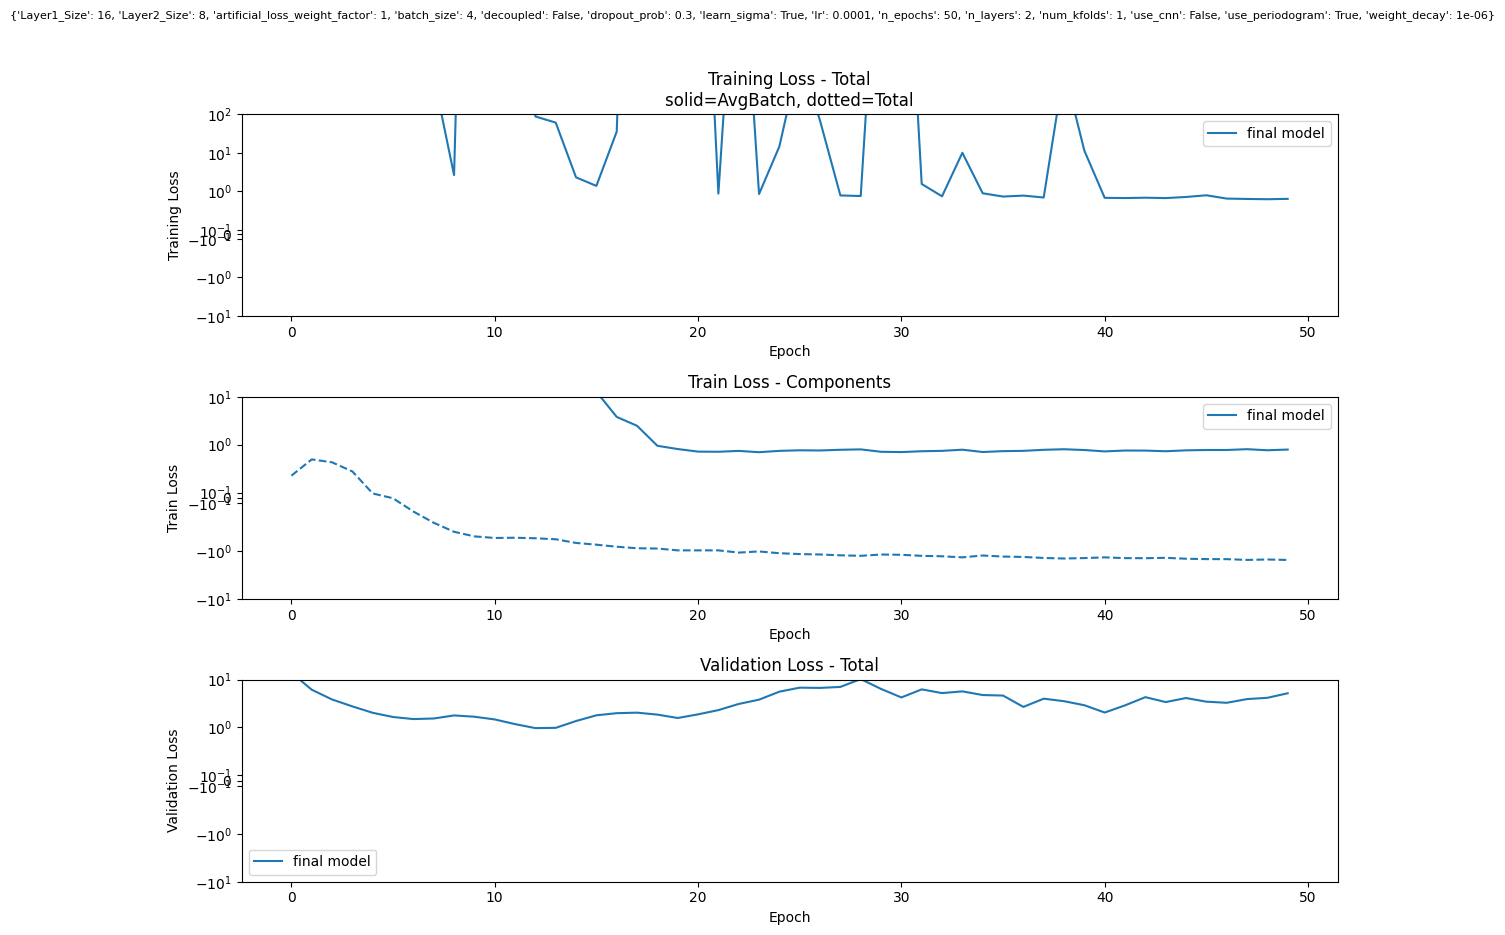

In [29]:
# ============================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================

# Plot training evolution
print("\nGenerating training plots...")
plot_run_log(final_model_log, kfold=False)

single-model


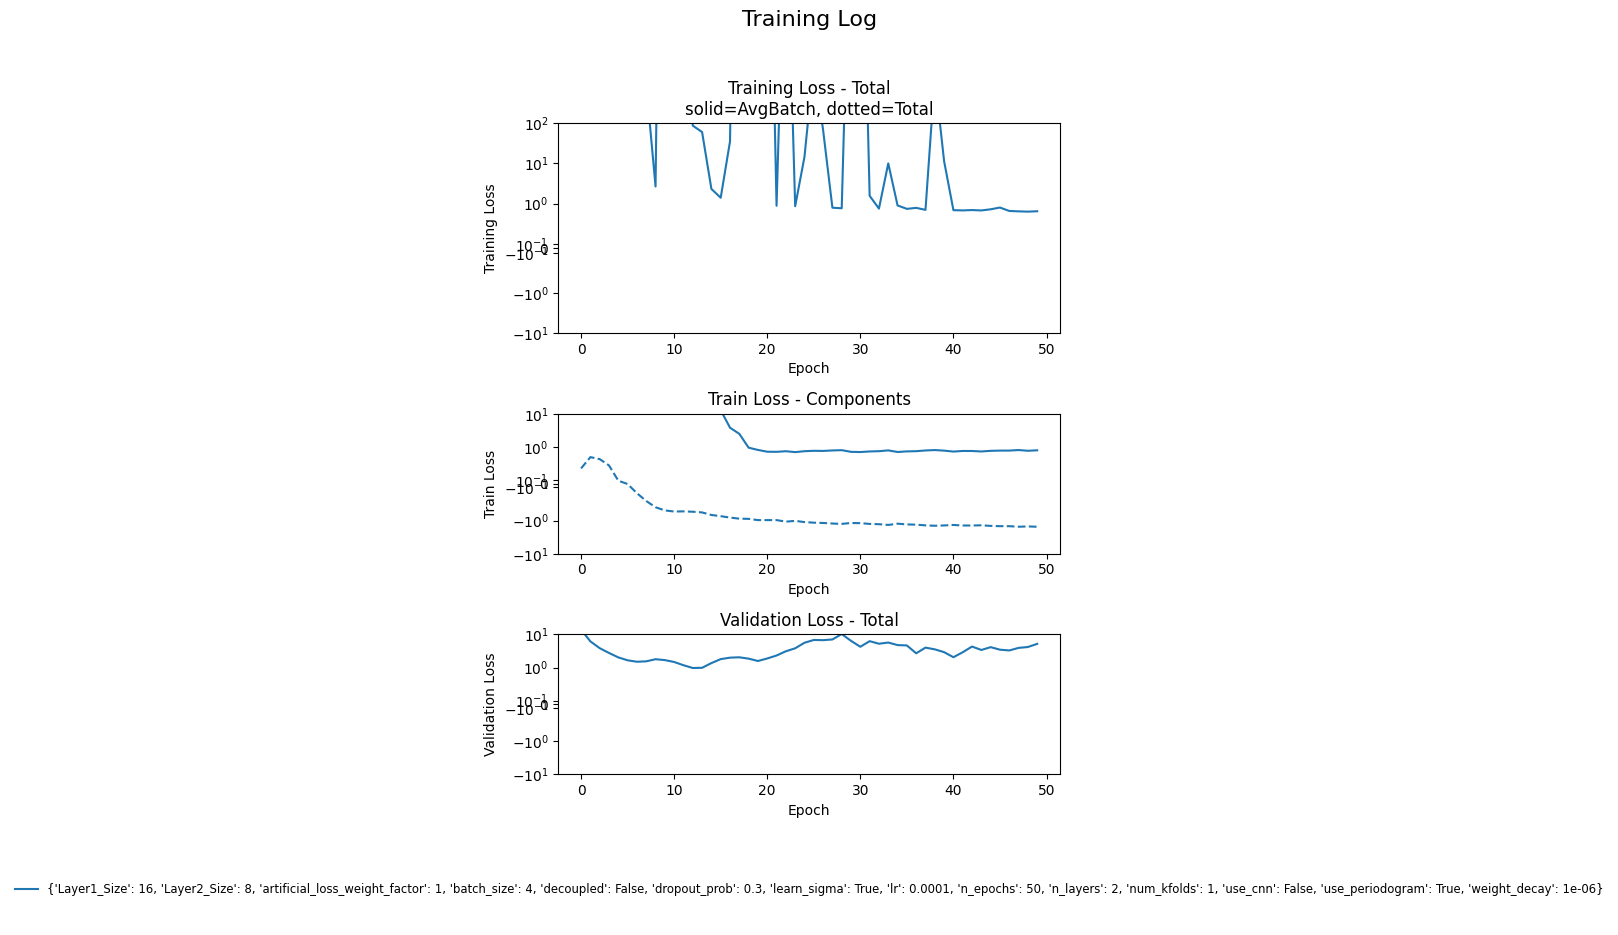

In [30]:
from Kfold_PlottingFcns import plot_trainval_loss_evolution, plot_all_metric_evolution
plot_trainval_loss_evolution(final_model_log, is_kfold=False)

In [31]:
print(final_model_log.keys())


dict_keys(['params', 'model', 'log', 'final_model', 'best_model_state', 'best_model_epoch'])


single_model
Run_id 0
      train_Loss = -0.741380; epoch = 49
      mean_batch_loss = 0.629889; epoch = 48
      train_Loss = -0.741380; epoch = 49
      valid_Loss = 0.968326; epoch = 12
      train_errLoss = 0.696958; epoch = 23
      valid_errLoss = 1.690232; epoch = 12
      train_sigmaLoss = -1.532062; epoch = 49
      valid_sigmaLoss = -1.719666; epoch = 49


/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Kfold_PlottingFcns.py:390: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[metric_id].set_ylim(new_ymin, new_ymax)


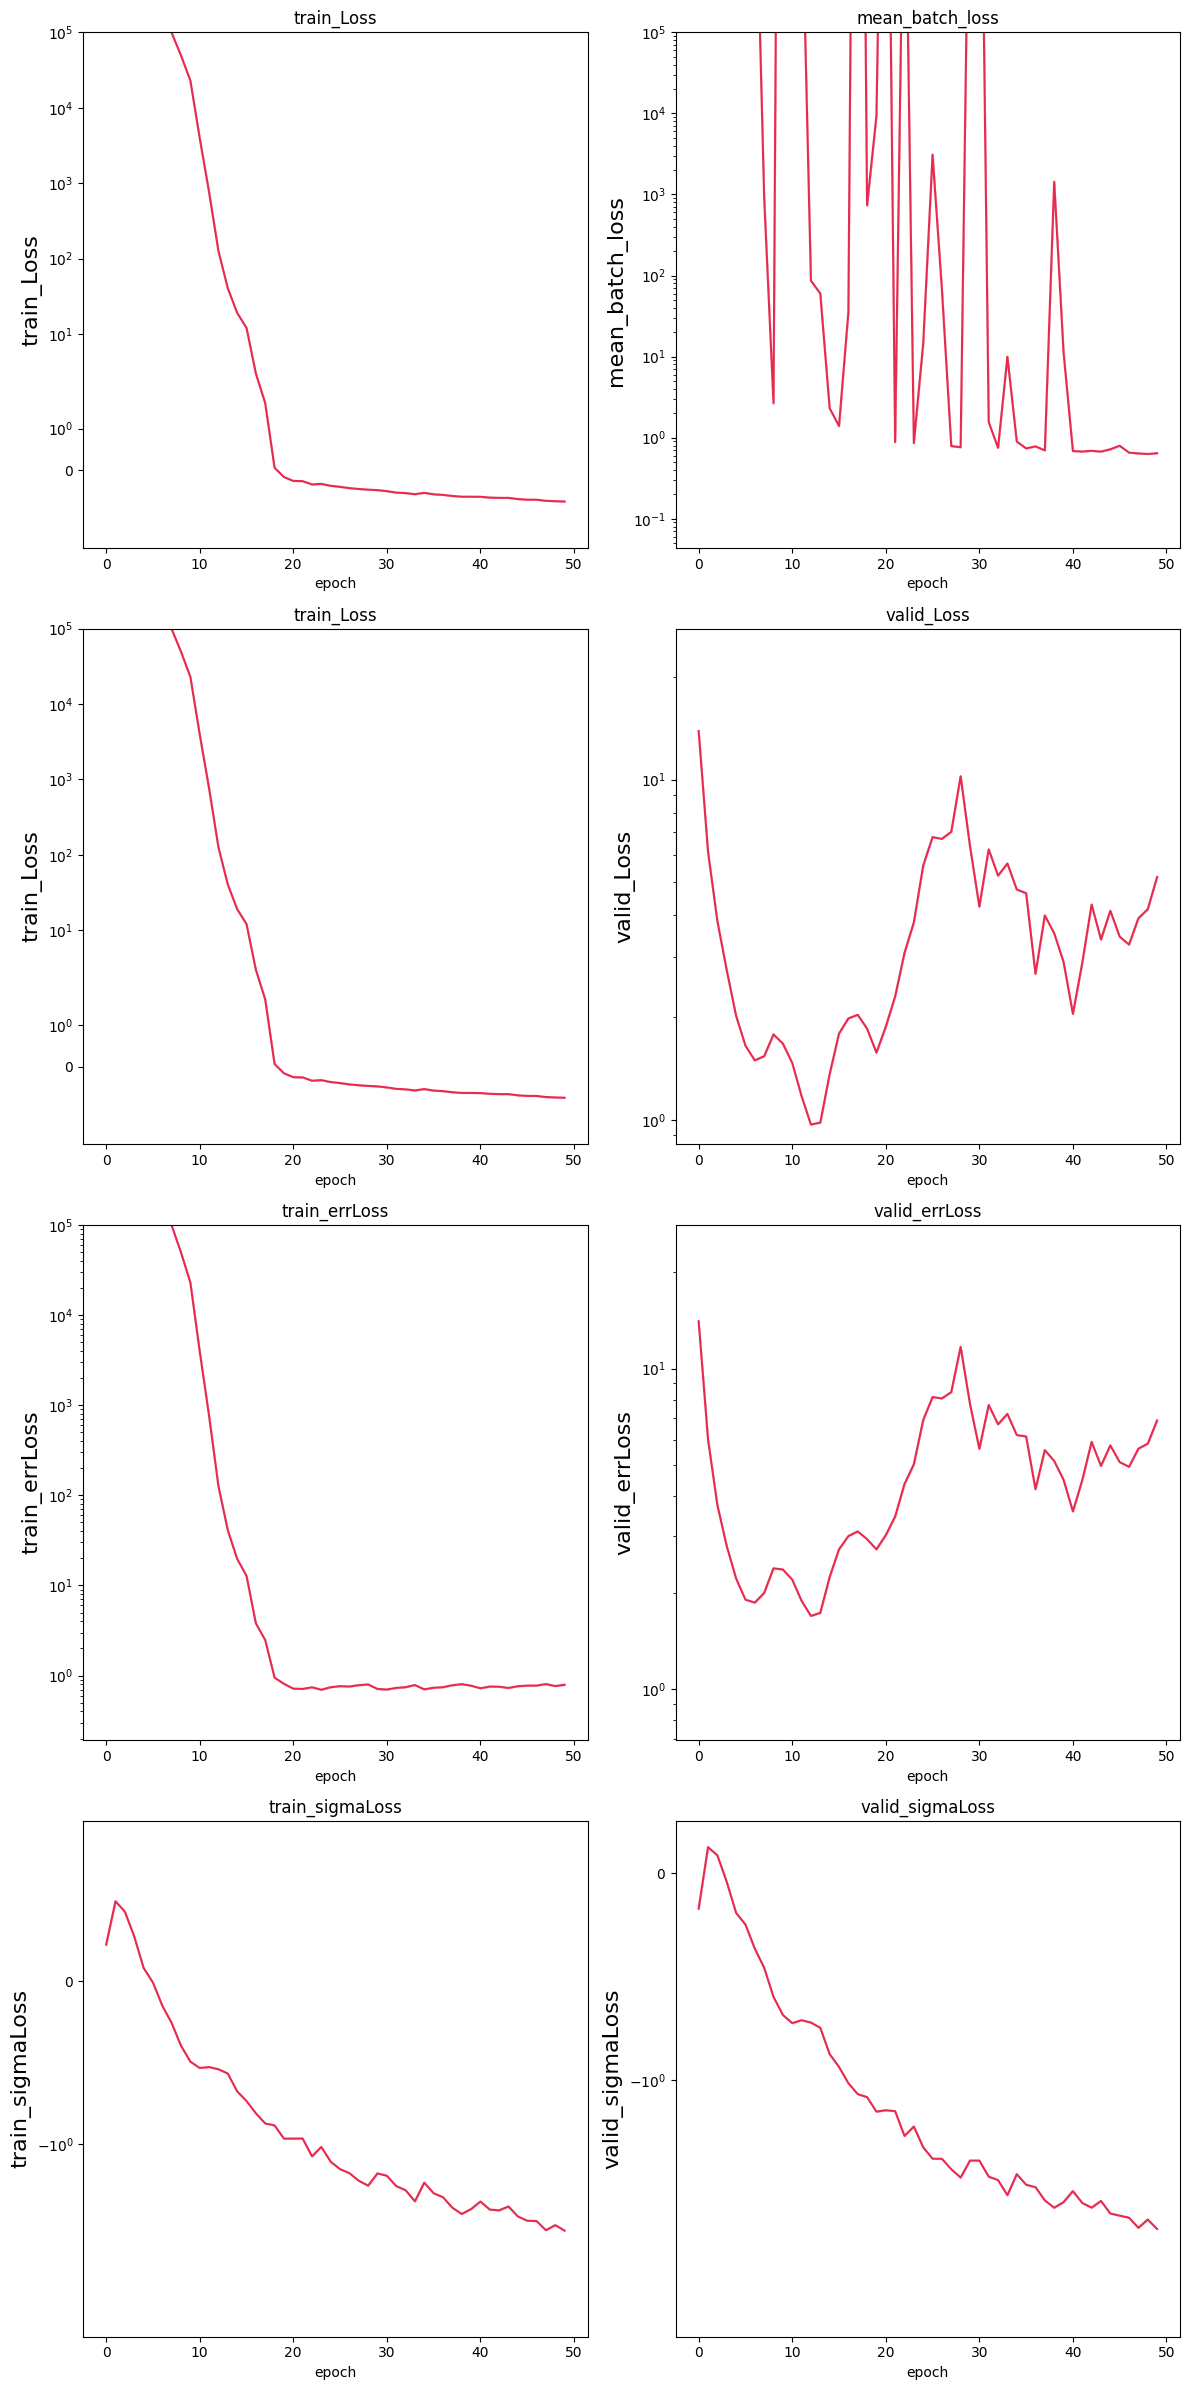

single_model
Run_id 0
      train_RMSE = 0.512172; epoch = 49
      valid_RMSE = 0.575345; epoch = 40
      train_MAE = 0.365408; epoch = 49
      valid_MAE = 0.413009; epoch = 40
      train_median_sigma = 0.460996; epoch = 49
      valid_median_sigma = 0.446459; epoch = 49
      train_mean_sigma = 0.515584; epoch = 47
      valid_mean_sigma = 0.457915; epoch = 47


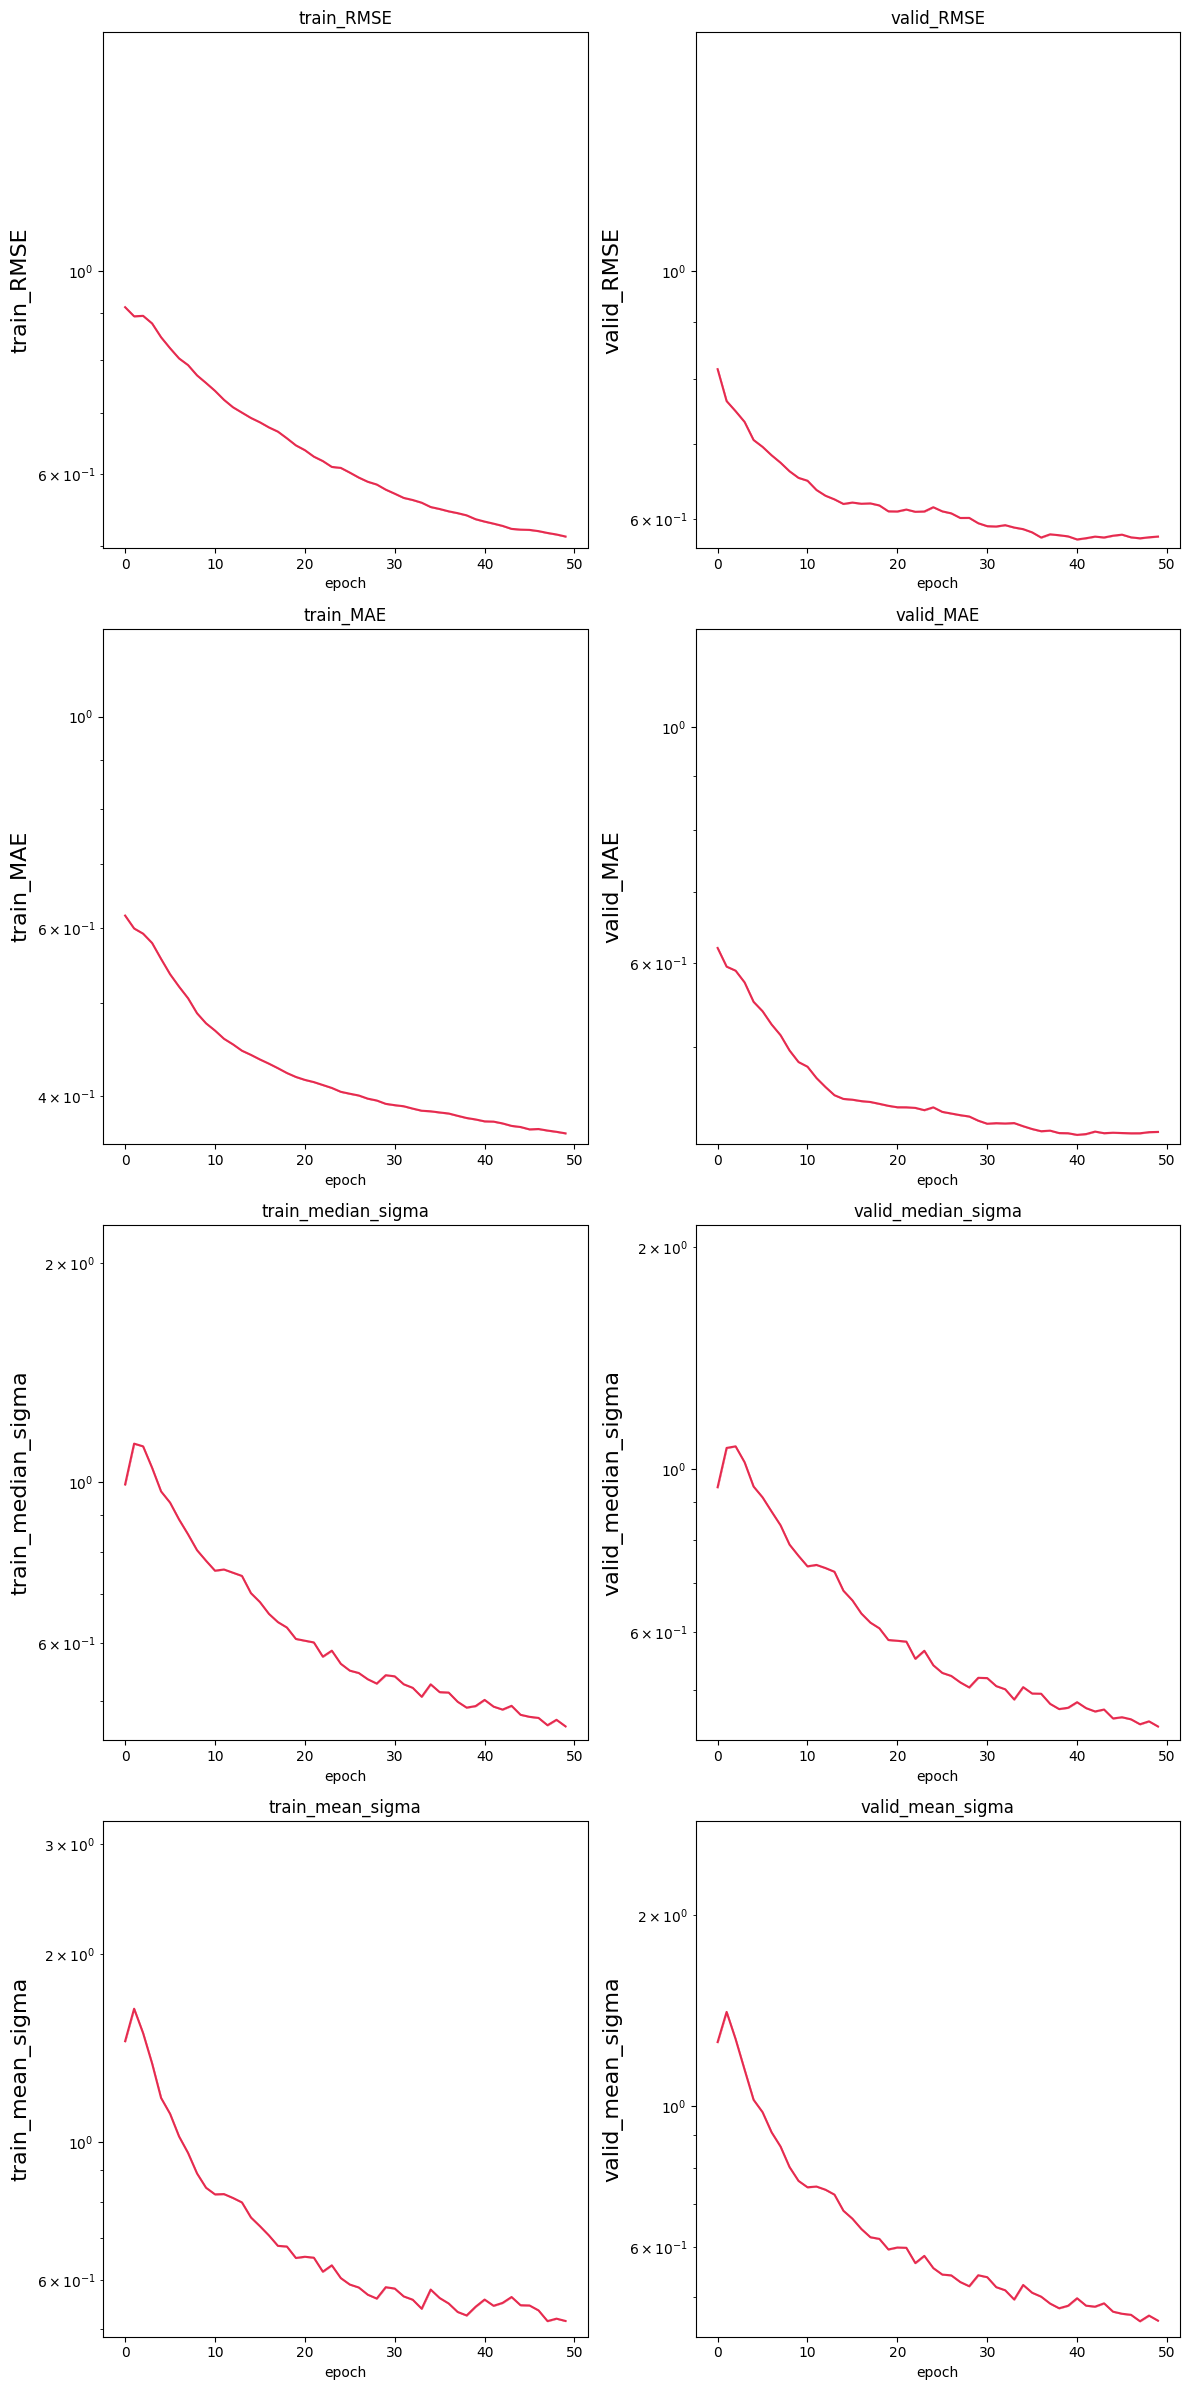

single_model
Run_id 0
      train_Coverage68 = 0.081905; epoch = 47
      valid_Coverage68 = 0.000088; epoch = 44
      train_Coverage95 = 0.008578; epoch = 0
      valid_Coverage95 = 0.017329; epoch = 3
      train_CRPS = 0.259218; epoch = 48
      valid_CRPS = 0.309477; epoch = 40


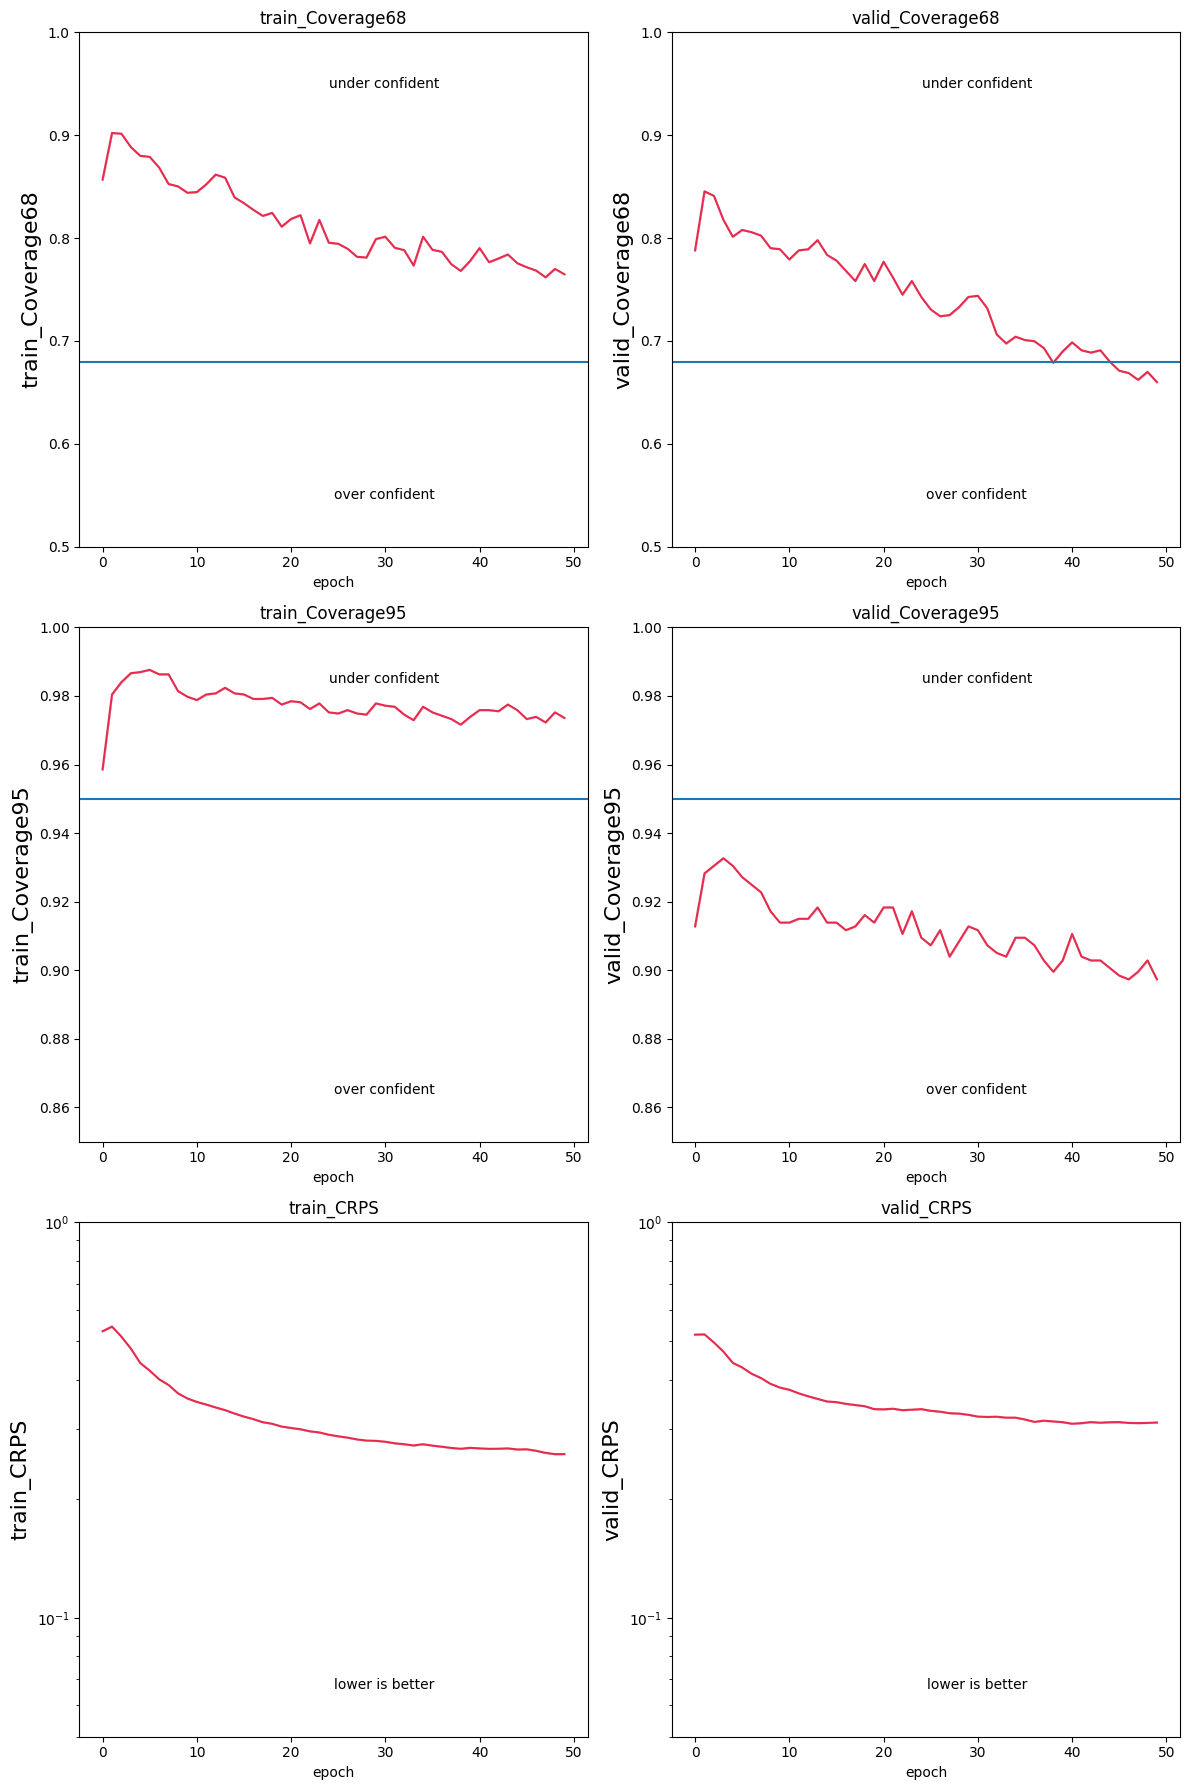

In [32]:
from Kfold_PlottingFcns import plot_all_metric_evolution
plot_all_metric_evolution(final_model_log, k_fold=False)

# Save Final Model

In [33]:
# ============================================================
# SAVE BEST MODEL
# ============================================================

print("\n" + "="*70)
print("SAVING BEST MODEL")
print("="*70)

# Load the BEST model weights back into the model object
# (This is the model with lowest smoothed validation loss, not the final epoch)
print(f"\n📌 Loading best model checkpoint from epoch {final_model_log['best_model_epoch']}...")
best_model = final_model_log['final_model']  # Get the model object
best_model.load_state_dict(final_model_log['best_model_state'])  # Load best weights
print(f"   ✅ Best model weights loaded")

# Prepare model package (saves the BEST model, not final epoch)
model_package = {
    'model_state_dict': best_model.state_dict(),  # BEST model weights
    'best_model_epoch': final_model_log['best_model_epoch'],  # Which epoch it came from
    'hyperparameters': best_params,
    'training_log': final_model_log['log'],
    'best_epoch_from_tuning': best_epoch,
    'composite_score': best_config['composite_score'],
    'scaler': SCALER,
    'y_mean': y_mean,
    'mean_peak_strength': mean_peak_strength,
    'feature_cols': feature_cols,
    'model_architecture': {
        'summary_dim': X_train.shape[1],  # FIXED: shape[1] = num features (17), not shape[0] = num samples
        'periodogram_dim': period_train.shape[1],
        'hidden_size': best_params['Layer1_Size'],
        'dropout_prob': best_params['dropout_prob'],
        'use_periodogram': best_params['use_periodogram'],
        'use_cnn': best_params['use_cnn'],
        'learn_sigma': best_params['learn_sigma']
    }
}

# Save to file
output_path = temp_files_path + 'final_model.pt'
torch.save(model_package, output_path)

print(f"\n✅ Model saved successfully!")
print(f"   Location: {output_path}")
print(f"\nModel package contains:")
print(f"   • Trained model weights (from BEST epoch: {final_model_log['best_model_epoch']})")
print(f"   • Best epoch number")
print(f"   • Hyperparameters")
print(f"   • Training log (all metrics)")
print(f"   • Scaler and preprocessing info (scaler, y_mean, mean_peak_strength)")
print(f"   • Model architecture details")
print(f"\n   💡 This is the model with the LOWEST smoothed validation loss (not final epoch)")
print("="*70)


SAVING BEST MODEL

📌 Loading best model checkpoint from epoch 13...
   ✅ Best model weights loaded

✅ Model saved successfully!
   Location: /Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/TempFiles/final_model.pt

Model package contains:
   • Trained model weights (from BEST epoch: 13)
   • Best epoch number
   • Hyperparameters
   • Training log (all metrics)
   • Scaler and preprocessing info (scaler, y_mean, mean_peak_strength)
   • Model architecture details

   💡 This is the model with the LOWEST smoothed validation loss (not final epoch)
